In [127]:
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Forward Contract Pricing

In [128]:
S = 100      # initial stock asset price
D = 0        # divident over the period
e = math.e   # euler number
r = .3       # risk free rate
t = 1/12     # time in years

In [129]:
def forward_calculation(S: float, D: float, e: float, r: float, t: float)-> float:
    return S * (1 + r * t) - D # forward contract price

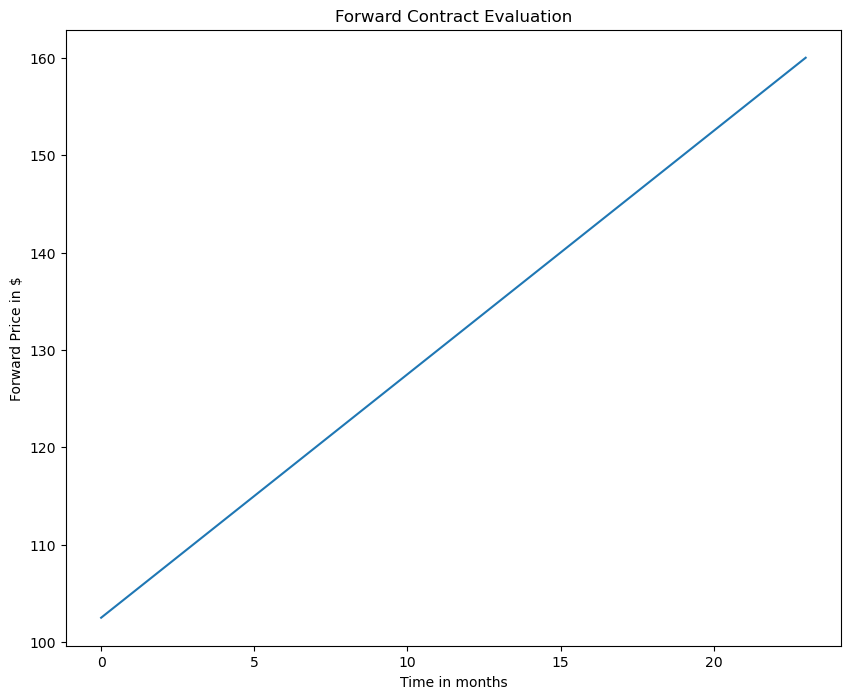

In [130]:
forward_prices = []
time_arr = []
time_in_months = 12 * 2

for i in range(time_in_months):
    forward_prices.append(forward_calculation(S, D, e, r, (i+1)/12))
    time_arr.append(i+1)

plt.subplots(figsize=(10, 8))
plt.plot(forward_prices)
plt.xlabel("Time in months")
plt.ylabel("Forward Price in $")
plt.title("Forward Contract Evaluation")
plt.show()

In [131]:
print(forward_prices)
print([time * 12 for time in time_arr])

[102.49999999999999, 105.0, 107.5, 110.00000000000001, 112.5, 114.99999999999999, 117.5, 120.0, 122.50000000000001, 125.0, 127.49999999999999, 130.0, 132.5, 135.0, 137.5, 140.0, 142.5, 145.0, 147.5, 150.0, 152.5, 154.99999999999997, 157.5, 160.0]
[12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288]


# Binomial Asset Pricing model

In [132]:
class BinomialTree:
    def __init__(self, r, t, S, K, sigma, N, trees_print = False, just_calc = False):
        self.r = r
        self.t = t
        self.S = S
        self.K = K
        self.sigma = sigma
        self.N = N
        self.trees_print = trees_print
        
        self.board = []
        self.eur_opt_put = []
        self.eur_opt_call = []
        self.am_opt_call = []
        self.am_opt_put = []
        
        self.biggest_num = 5
        self.empty_line = " "
        
        self.call_price = 0
        self.put_price = 0
        self.am_call_price = 0
        self.am_put_price = 0
        
        self.calc()
        
        if not just_calc:
            self.print_trees()
            
    def __str__():
        return "< r={} t={} S={} K={} sigma={} N={} >".format(self.r, self.t, self.S, self.K, self.sigma, self.N)
    
    def calc(self):
        
        r = self.r              
        t = self.t              
        S = self.S
        K = self.K
        rows = self.N           
        sigma = self.sigma      

        dt = t/(rows - 1)
        u = math.e**(sigma*math.sqrt(dt))
        d = 1/u          
        cols = 2*(rows - 1) + 4
        p = (math.e ** (r * dt) - d) / (u - d)

        board = self.board
        biggest_num = 1
        
        put_price = 0
        call_price = 0
        am_call_price = 0
        am_put_price = 0

        for row in range(rows):
            board.append([])
            for col in range(cols):
                board[row].append([])

                if col == cols/2 and row == 0:
                    board[row][col] = S
                elif row != 0 and col != 0 and col != cols-1 and ( board[row-1][col-1] != self.empty_line or board[row-1][col+1] != self.empty_line ):
                    if board[row-1][col-1] != self.empty_line:
                        board[row][col] = str(float(board[row-1][col-1]) * d)
                    else:
                        board[row][col] = str(float(board[row-1][col + 1]) * u)            
                else:
                    board[row][col] = self.empty_line        

        for row in range(rows):
            for col in range(cols):
                if board[row][col] != self.empty_line and len(str(round(float(board[row][col]), 2))) > biggest_num:
                    biggest_num = len(str(round(float(board[row][col]), 2)))
        self.biggest_num = biggest_num

        eur_opt_put = copy.deepcopy(board)
        self.eur_opt_put = eur_opt_put
        eur_opt_call = copy.deepcopy(board)
        self.eur_opt_call = eur_opt_call
        am_opt_call = copy.deepcopy(board)
        self.am_opt_call = am_opt_call
        am_opt_put = copy.deepcopy(board)
        self.am_opt_put = am_opt_put

        # European Put Option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if eur_opt_put[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    eur_opt_put[row][col] = max(K - float(eur_opt_put[row][col]), 0)
                else:
                    eur_opt_put[row][col] = math.e**((-r)*dt) * (p * (eur_opt_put[row + 1][col - 1]) + (1-p) * (eur_opt_put[row + 1][col + 1]))
                    if row == 0:
                        put_price = eur_opt_put[row][col]

        # European Call Option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if eur_opt_call[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    eur_opt_call[row][col] = max(float(eur_opt_call[row][col]) - K, 0)
                else:
                    eur_opt_call[row][col] = math.e**((-r)*dt) * (p * (eur_opt_call[row + 1][col - 1]) + (1-p) * (eur_opt_call[row + 1][col + 1]))
                    if row == 0:
                        call_price = eur_opt_call[row][col]
                        
        # American Call Option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if am_opt_call[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    am_opt_call[row][col] = max(float(am_opt_call[row][col]) - K, 0)
                else:
                    am_opt_call[row][col] = math.e**((-r)*dt) * (p * (am_opt_call[row + 1][col - 1]) + (1-p) * (am_opt_call[row + 1][col + 1]))
                    if float(am_opt_call[row][col]) < float(board[row][col]) - K:
                        am_opt_call[row][col] = float(board[row][col]) - K
                    if row == 0:
                        am_call_price = am_opt_call[row][col]
                        
        # American Put option
        for row in range(rows - 1, -1, -1):
            for col in range(cols):
                if am_opt_put[row][col] == self.empty_line:
                    continue
                elif row == (rows - 1):
                    am_opt_put[row][col] = max(K - float(am_opt_put[row][col]), 0)
                else:
                    am_opt_put[row][col] = math.e**((-r)*dt) * (p * (am_opt_put[row + 1][col - 1]) + (1-p) * (am_opt_put[row + 1][col + 1]))
                    if float(am_opt_put[row][col]) < K - float(board[row][col]):
                        am_opt_put[row][col] = K - float(board[row][col])
                    if row == 0:
                        am_put_price = am_opt_put[row][col]
        
        self.call_price = call_price
        self.put_price = put_price
        self.am_call_price = am_call_price
        self.am_put_price = am_put_price
                        
    def print_trees(self):
        
        rows = self.N  
        cols = 2*(rows - 1) + 4
        
        board = self.board
        eur_opt_put = self.eur_opt_put
        eur_opt_call = self.eur_opt_call
        am_opt_put = self.am_opt_put
        am_opt_call = self.am_opt_call
        
        put_price = self.put_price
        call_price = self.call_price
        am_put_price = self.am_put_price
        am_call_price = self.am_call_price
        
        biggest_num = self.biggest_num
        
        if rows <= 16 and self.trees_print:
            heading = "Binomial Asset Pricing Model(Asset) - initial asset price is: " + str(S) + "$"
            print(heading)
            for col in range(cols):
                for row in range(rows):
                    if board[row][col] == self.empty_line:
                        print("".ljust(biggest_num), end="")
                    else:
                        print(str(round(float(board[row][col]), 2)).ljust(biggest_num), end="")
                print()

            heading = "Binomial Asset Pricing Model(Option) - European Put Price " + str(put_price) + "$"
            print(heading)
            for col in range(cols):
                for row in range(rows):
                    if board[row][col] == self.empty_line:
                        print("".ljust(biggest_num), end="")
                    else:
                        print(str(round(eur_opt_put[row][col], 2)).ljust(biggest_num), end="")
                print()

            heading = "Binomial Asset Pricing Model(Option) - European Call Price " + str(call_price) + "$"
            print(heading)
            for col in range(cols):
                for row in range(rows):
                    if board[row][col] == self.empty_line:
                        print("".ljust(biggest_num), end="")
                    else:
                        print(str(round(eur_opt_call[row][col], 2)).ljust(biggest_num), end="")
                print()
                
            heading = "Binomial Asset Pricing Model(Option) - American Call Price"
            print(heading)
            for col in range(cols):
                for row in range(rows):
                    if board[row][col] == self.empty_line:
                        print("".ljust(biggest_num), end="")
                    else:
                        print(str(round(am_opt_call[row][col], 2)).ljust(biggest_num), end="")
                print()
                
            heading = "Binomial Asset Pricing Model(Option) - American Put Price"
            print(heading)
            for col in range(cols):
                for row in range(rows):
                    if board[row][col] == self.empty_line:
                        print("".ljust(biggest_num), end="")
                    else:
                        print(str(round(am_opt_put[row][col], 2)).ljust(biggest_num), end="")
                print()
        else:
            print("Eu Put Price:", 
                  str(put_price), 
                  "\nEu Call Price:", 
                  str(call_price),
                  "\nAm Put Price: ", 
                  str(am_put_price),
                  "\nAm Call Price: ", 
                  str(am_call_price))           

# Black-Scholes Merton Model

\begin{equation}
C(S_{t},K,t)=S_{t}\Phi (d_{1})-Ke^{-r(T-t)}\Phi (d_{2})
\end{equation}
\begin{equation}
P(S_{t},K,t)=Ke^{-r(T-t)}\Phi (-d_{2})-S_{t}\Phi (-d_{1})
\end{equation}
\begin{equation}
d_{1}=\frac{\ln\frac{S_{t}}{K} + (r + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}
\end{equation}
\begin{equation}
d_{2}=d_{1}-\sigma\sqrt{\tau}
\end{equation}

\begin{equation}
	\frac{\partial \mathrm C}{ \partial \mathrm t } + \frac{1}{2}\sigma^{2} \mathrm S^{2} \frac{\partial^{2} \mathrm C}{\partial \mathrm C^2}
	+ \mathrm r \mathrm S \frac{\partial \mathrm C}{\partial \mathrm S}\ =
	\mathrm r \mathrm C 
	\label{eq:1}
\end{equation}

In [133]:
import numpy as np
from scipy.stats import norm

In [134]:
class BlackScholes:
    def __init__(self, r, S, K, T, sigma):
        self.r = r
        self.S = S
        self.K = K
        self.T = T
        self.sigma = sigma
        
        self.asset_prices_calc()
    
    def asset_prices_calc(self):
        "Calculate BS price of call/put"
        r = self.r
        S = self.S
        K = self.K
        T = self.T
        sigma = self.sigma
        
        call_price = 0
        put_price = 0
        
        d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)

        
        call_price = price = S*norm.cdf(d1, 0, 1) - K*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        put_price = price = K*np.exp(-r*T)*norm.cdf(-d2, 0, 1) - S*norm.cdf(-d1, 0, 1)

        return call_price, put_price
    
    def delta_calc(self):
        "Calculate delta of an option"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        
        delta_call_calc = 0
        delta_put_calc = 0
        
        delta_call_calc = norm.cdf(d1, 0, 1)
        delta_put_calc = -norm.cdf(-d1, 0, 1)
        
        return delta_call_calc, delta_put_calc
    
    def gamma_calc(self):
        "Calculate gamma of a option"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        gamma_calc = norm.pdf(d1, 0, 1)/(self.S*self.sigma*np.sqrt(self.T))
        
        return gamma_calc
    
    def vega_calc(self):
        "Calculate BS price of call/put"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        vega_calc = S*norm.pdf(d1, 0, 1)*np.sqrt(self.T)
        
        return vega_calc*0.01
    
    def theta_calc(self):
        "Calculate BS price of call/put"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)

        theta_call_calc = 0
        theta_put_calc = 0

        theta_call_calc = -self.S*norm.pdf(d1, 0, 1)*self.sigma/(2*np.sqrt(self.T)) - self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(d2, 0, 1)
        theta_put_calc = -self.S*norm.pdf(d1, 0, 1)*self.sigma/(2*np.sqrt(self.T)) + self.r*self.K*np.exp(-self.r*self.T)*norm.cdf(-d2, 0, 1)

        return theta_call_calc/365, theta_put_calc/365
    
    def rho_calc(self):
        "Calculate BS price of call/put"
        d1 = (np.log(self.S/self.K) + (self.r + self.sigma**2/2)*self.T)/(self.sigma*np.sqrt(self.T))
        d2 = d1 - self.sigma*np.sqrt(self.T)
        
        rho_call_calc = 0
        rho_put_calc = 0
        
        rho_call_calc = K*T*np.exp(-r*T)*norm.cdf(d2, 0, 1)
        rho_put_calc = -K*T*np.exp(-r*T)*norm.cdf(-d2, 0, 1)
        
        return rho_call_calc*0.01, rho_put_calc*0.01

### All calculations

In [162]:
# Variables have to be identical to see if the models produce similar results

r = .05       # risk free rate
S = 20        # initial stock price
K = 20        # strike price
T = 1         # time in years
sigma = 0.4   # volatility
N = 10        # number of rows in binomial tree

In [163]:
binomial = BinomialTree(r, T, S, K, sigma, N, False)

BS = BlackScholes(r, S, K, T, sigma)
print("BS -> Eu Call Price", BS.asset_prices_calc()[0], "Eu Put Price", BS.asset_prices_calc()[1])

Eu Put Price: 2.7117350630207717 
Eu Call Price: 3.6871465730065056 
Am Put Price:  2.8112901574362565 
Am Call Price:  3.6871465730065056
BS -> Eu Call Price 3.604590290043335 Eu Put Price 2.629178780057618


In [164]:
print(BS.asset_prices_calc(),
     BS.delta_calc(),
     BS.gamma_calc(),
     BS.vega_calc(),
     BS.theta_calc(),
     BS.rho_calc(),
     sep="\n")

(3.604590290043335, 2.629178780057618)
(0.627409464153284, -0.372590535846716)
0.04730247899172744
0.0756839663867639
(-0.005372217198318891, -0.0027661091859881672)
(0.08943598993022345, -0.10080989496991938)


## Difference between Binomial and Black Scholes Model

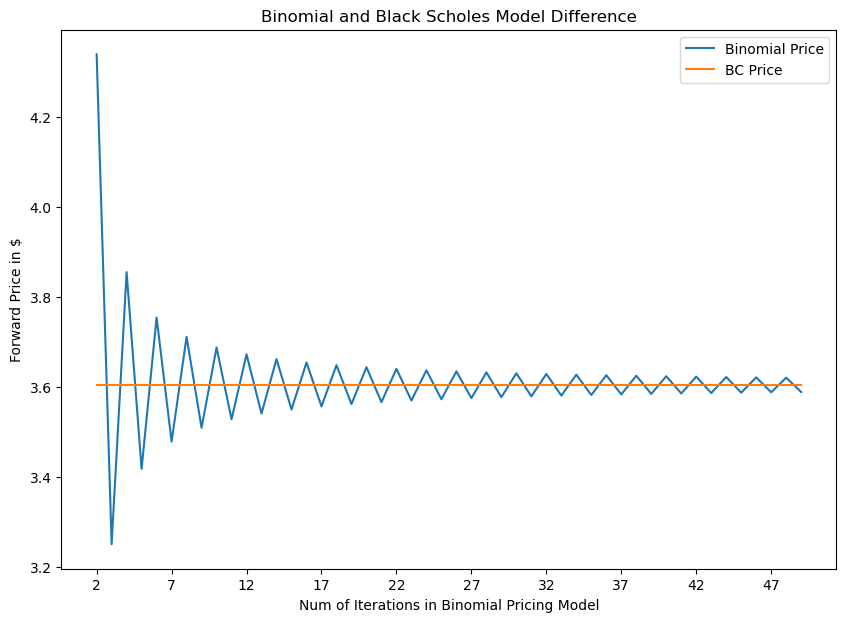

In [171]:
r = .05               # risk free rate
S = 20                # initial stock price
K = 20                # strike price
T = 1                 # time in years
iterations = 50       # number of iterations
sigma = 0.4           # volatility
binom_prices = []     # list of prices calculated by the binomial pricing model
binom_iterations = [] # iterations x-axys

for N in range(2, iterations):
    binom_prices.append(BinomialTree(r, T, S, K, sigma, N, False, True).call_price)
    binom_iterations.append(N)

BS = BlackScholes(r, S, K, T, sigma)    

plt.subplots(figsize=(10, 7))
plt.plot(binom_iterations, binom_prices)
plt.plot(binom_iterations, [BS.asset_prices_calc()[0]] * len(binom_prices))
plt.xticks(np.arange(2, iterations, step=int(iterations/10)))
plt.legend(['Binomial Price', 'BC Price'])
plt.xlabel("Num of Iterations in Binomial Pricing Model")
plt.ylabel("Forward Price in $")
plt.title("Binomial and Black Scholes Model Difference")
plt.show()